[*********************100%%**********************]  2 of 2 completed


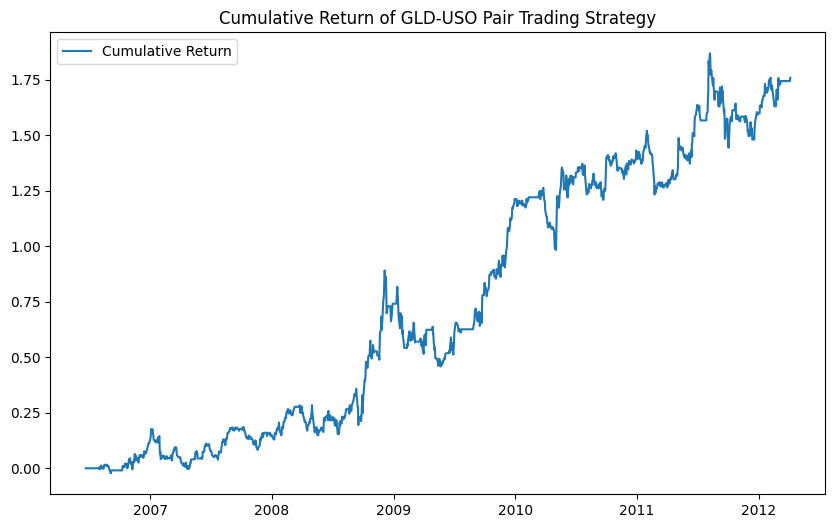

APR = 0.191533, Sharpe Ratio = 1.030652


In [31]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm

# Custom functions for moving average and standard deviation
def movingAvg(arr, window):
    return arr.rolling(window=window).mean()

def movingStd(arr, window):
    return arr.rolling(window=window).std()

def fillMissingData(arr):
    return arr.ffill()

# Download data
tickers = ['GLD', 'USO']
data = yf.download(tickers,  start='2006-05-24', end='2012-04-09')["Adj Close"].dropna()

x = data['GLD'] # GLD prices
y = data['USO'] # USO prices

# Align both time series
x, y = x.align(y, join='inner')

# Lookback period
lookback = 20

# Hedge ratio calculation using rolling OLS regression
hedgeRatio = np.full(len(x), np.nan)
for t in range(lookback, len(x)):
    X = sm.add_constant(x[t-lookback:t])  # Adding constant term
    model = sm.OLS(y[t-lookback:t], X).fit()
    hedgeRatio[t] = model.params.iloc[1]  # Hedge ratio is the slope (beta of x)

# Creating the portfolio
y2 = pd.DataFrame({'GLD': x, 'USO': y})
yport = -hedgeRatio * y2['GLD'] + y2['USO']  # Portfolio spread

# Removing NaN values
yport = yport.iloc[lookback:]
hedgeRatio = hedgeRatio[lookback:]
y2 = y2.iloc[lookback:]

# Bollinger Band strategy
entryZscore = 1
exitZscore = 0

MA = movingAvg(yport, lookback)
MSTD = movingStd(yport, lookback)
zScore = (yport - MA) / MSTD

# Long and short entry/exit signals
longsEntry = zScore < -entryZscore
longsExit = zScore > -exitZscore
shortsEntry = zScore > entryZscore
shortsExit = zScore < exitZscore

# Position sizing for longs and shorts
numUnitsLong = np.full(len(yport), np.nan)
numUnitsShort = np.full(len(yport), np.nan)

# Initialize positions
numUnitsLong[0] = 0
numUnitsLong[longsEntry] = 1
numUnitsLong[longsExit] = 0
numUnitsLong = fillMissingData(pd.Series(numUnitsLong)).values

numUnitsShort[0] = 0
numUnitsShort[shortsEntry] = -1
numUnitsShort[shortsExit] = 0
numUnitsShort = fillMissingData(pd.Series(numUnitsShort)).values

# Net units long or short
numUnits = numUnitsLong + numUnitsShort

# Calculate positions (capital allocation in each ETF)
positions = pd.DataFrame({
    'GLD': numUnits * -hedgeRatio * y2['GLD'],
    'USO': numUnits * y2['USO']
})

# Lagging positions for P&L calculation
lag_positions = positions.shift(1)
lag_y2 = y2.shift(1)

# Calculate daily P&L
pnl = (lag_positions * (y2 - lag_y2) / lag_y2).sum(axis=1)
ret = pnl / lag_positions.abs().sum(axis=1)
ret.fillna(0, inplace=True)

# Plot cumulative compounded returns
cumulative_return = (1 + ret).cumprod() - 1
plt.figure(figsize=(10, 6))
plt.plot(cumulative_return, label="Cumulative Return")
plt.title('Cumulative Return of GLD-USO Pair Trading Strategy')
plt.legend()
plt.show()

# APR and Sharpe Ratio
apr = (1 + ret).prod() ** (252 / len(ret)) - 1
sharpe_ratio = np.sqrt(252) * ret.mean() / ret.std()

print(f'APR = {apr:.6f}, Sharpe Ratio = {sharpe_ratio:.6f}')